In [12]:
#Importamos datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [13]:
# Cargar el dataset
data = pd.read_csv("Temp_Asu20092021.csv")

# Convertir la columna 'Fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

#Chequeamos los datos
data.sample(5)


,Unnamed: 0,Temperatura,Humedad
Fecha,,,
2020-02-15 21:00:00,32503,35.417522,45.701582
2019-11-09 09:00:00,31715,24.091072,74.225361
2019-07-20 12:00:00,30820,18.340835,81.198137
2019-05-04 18:00:00,30206,29.960346,67.879293
2021-01-17 21:00:00,35199,20.364034,86.443589


In [14]:
# Resamplear el conjunto de datos a intervalos diarios y calcular la temperatura máxima diaria
daily_max_temperatures = data['Temperatura'].resample('D').max()

salida= daily_max_temperatures .shift(-1) #Genera la estructura de predición para el siguiente dia
salida.head()

Fecha
2019-01-01    37.610636
2019-01-02    38.163652
2019-01-03    37.351168
2019-01-04    34.843885
2019-01-05    36.485754
Freq: D, Name: Temperatura, dtype: float64

In [25]:

# Definir características (features) y variable objetivo (target)
X = daily_max_temperatures.values[:-1]  # Puedes agregar más características según sea necesario
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1))

# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = (daily_max_temperatures.index.year <= 2020)[:-1]
val_indices = (daily_max_temperatures.index.year == 2021)[:-1]

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]


# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de validación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error en validación: {mse}")
print(np.sqrt(mse))

# Asegurarse de que no haya ceros en los valores reales para evitar divisiones por cero
daily_max_temperatures_recortado = daily_max_temperatures_recortado.replace(0, np.nan)

# Calcular el MAPE (Error Porcentual Absoluto Medio)
mape = np.mean(np.abs((daily_max_temperatures_recortado - y_pred) / daily_max_temperatures_recortado)) * 100

print(f'MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores hiperparámetros:
{'alpha': 0.01}
Mean Squared Error en validación: 16.750342447107773
4.0927182222952725
MAPE (Error Porcentual Absoluto Medio): 20.10%


In [31]:
# Calculo paso a paso de R^2

# Paso 1: Calcular la media de los valores reales (daily_max_temperatures_clean)
y_mean = np.mean(daily_max_temperatures_clean)

# Paso 2: Calcular la suma de los cuadrados de los errores de las predicciones (SS_res)
ss_res = np.sum((daily_max_temperatures_clean - y_pred_clean) ** 2)

# Paso 3: Calcular la suma de los cuadrados totales (SS_tot) respecto a la media de los valores reales
ss_tot = np.sum((daily_max_temperatures_clean - y_mean) ** 2)

# Paso 4: Calcular R^2 usando la fórmula
r2 = 1 - (ss_res / ss_tot)

print(f'R^2 = {r2}')

#Falta mejorar el modelo

R^2 = -0.02574878622099619


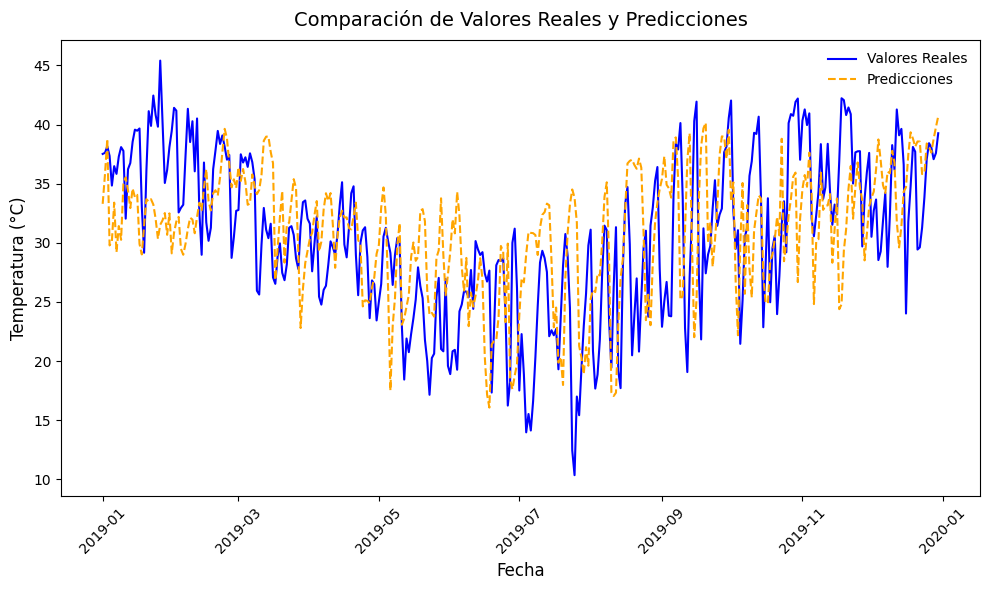

In [32]:
# Crear el gráfico de comparación entre valores reales y predicciones

plt.figure(figsize=(10, 6))

# Graficar los valores reales (recortados para que coincidan con las predicciones)
plt.plot(daily_max_temperatures_clean.index, daily_max_temperatures_clean, label='Valores Reales', color='blue', linewidth=1.5)

# Graficar las predicciones
plt.plot(daily_max_temperatures_clean.index, y_pred_clean, label='Predicciones', color='orange', linestyle='--', linewidth=1.5)

# Añadir etiquetas y título
plt.title('Comparación de Valores Reales y Predicciones', fontsize=14, pad=10)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Añadir la leyenda
plt.legend(frameon=False, fontsize=10)

# Mostrar la gráfica
plt.tight_layout()
plt.show()
